In [198]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import Normalizer,StandardScaler , PowerTransformer, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer#IterativeImputer
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, KFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn import set_config
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.experimental import enable_iterative_imputer  
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, StackingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import optuna
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV, ShapleyImportanceEvaluator
from optuna.visualization import plot_param_importances
import re
import feature_engine as fe
import category_encoders as ce

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
#nltk.download('punkt')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


#from catboost import CatBoostRegressor



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [199]:
# 시각화 패키지
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 필요한 패키지
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [200]:
# 한글 폰트 설정
from matplotlib import font_manager, rc
import platform

your_os = platform.system()
if your_os == 'Linux':
    rc('font', family = 'NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family = font_name)
elif your_os == 'Darwin':
    rc('font', family = 'AppleGothic')
rc('axes', unicode_minus = False)

In [201]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
park_df = pd.read_csv('data/park.csv')
care_df = pd.read_csv('data/day_care_center.csv')
submission_df = pd.read_csv('data/submission.csv')


se_subway = pd.read_csv('data/서울지하철.csv', encoding = 'cp949')
pu_subway = pd.read_csv('data/부산지하철.csv', encoding = 'cp949')
pu_hos = pd.read_csv('data/부산병원.csv', encoding = 'cp949')
se_hos = pd.read_csv('data/서울병원.csv', encoding = 'cp949')
pu_aca = pd.read_csv('data/부산학원.csv', encoding = 'cp949')
pu_gyo = pd.read_csv('data/부산교습소.csv', encoding = 'cp949')
se_aca = pd.read_csv('data/서울학원.csv', encoding = 'cp949')
phar = pd.read_csv('data/전국약국.csv', encoding = 'cp949')

se_mar = pd.read_csv('data/상권정보_서울.csv', encoding = 'utf-8')
pu_mar = pd.read_csv('data/상권정보_부산.csv', encoding = 'utf-8')
care_se = pd.read_csv('data/서울시 어린이집 정보(표준 데이터).csv', encoding = 'cp949')
care_pu = pd.read_csv('data/부산어린이집.csv', encoding = 'cp949')
sungdong = pd.read_csv('data/성동구.csv', encoding = 'cp949')


# 1. 추가데이터, 기존 데이터에 대한 생성 및 전처리

    Train, Test

In [202]:
len(test_df)

364966

In [203]:
test_id = test_df.transaction_id


train_df = train_df.drop(['transaction_id','apartment_id','addr_kr', 'jibun', 'apt'],axis=1)
test_df = test_df.drop([ 'apartment_id','addr_kr', 'jibun', 'apt'],axis=1)


###############################################################################

train_df.loc[train_df['transaction_date'] == '1~10', 'transaction_date'] = 1
train_df.loc[train_df['transaction_date'] == '11~20', 'transaction_date'] = 2
train_df.loc[train_df['transaction_date'] != int, 'transaction_date'] = 3

test_df.loc[test_df['transaction_date'] == '1~10', 'transaction_date'] = 1
test_df.loc[test_df['transaction_date'] == '11~20', 'transaction_date'] = 2
test_df.loc[test_df['transaction_date'] != int, 'transaction_date'] = 3

###############################################################################

    동별 중위수 가격

In [204]:
# test에는 y값이 없기 때문에 train기준으로 산출된 값을 test에 적용.
# 평균보다 robust한 median으로 설정.
# train 데이터프레임에서 동별 중위수 가격 계산
average_price_train = train_df.groupby('dong')['transaction_real_price'].median().reset_index()
average_price_train.columns = ['dong', 'average_price']

# train 데이터프레임에 동별 중위수 가격을 추가
train_df['average_price'] = train_df['dong'].map(average_price_train.set_index('dong')['average_price']).fillna(0).astype(int)

# test 데이터프레임에 동별 중위수 가격을 추가
test_df['average_price'] = test_df['dong'].map(average_price_train.set_index('dong')['average_price']).fillna(0).astype(int)




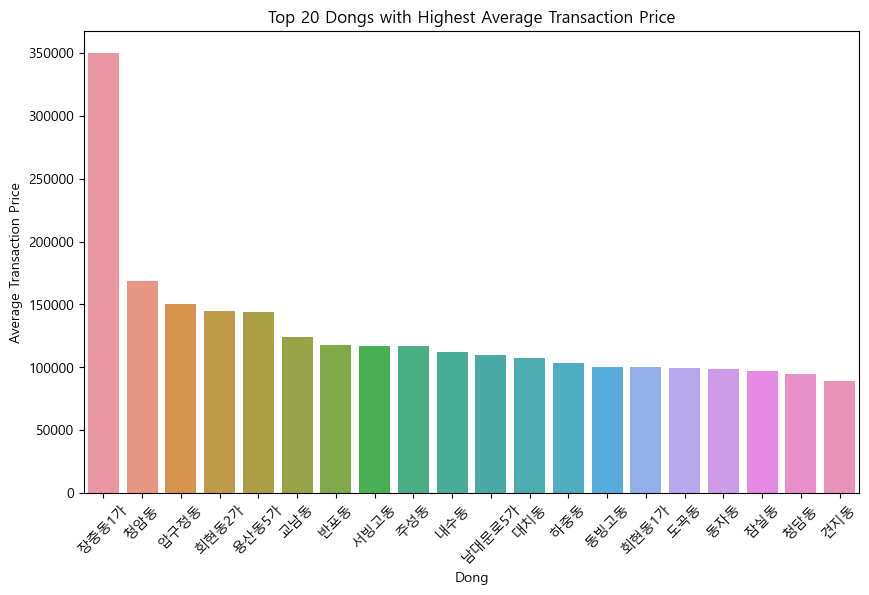

In [205]:
#동별 평균 거래 가격 상위 20
top10_dongs = average_price_train.sort_values('average_price', ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top10_dongs['dong'], y=top10_dongs['average_price'])
plt.title('Top 20 Dongs with Highest Average Transaction Price')
plt.xlabel('Dong')
plt.ylabel('Average Transaction Price')
plt.xticks(rotation=45)
plt.show()


    역세권

In [206]:
## 서울 ##
se_subway['dong'] = se_subway['도로명주소'].str.extract(r'\((.*?)\)', expand=False) # 주소 혼용 데이터에서 동만 추출

dong_line_counts = se_subway.groupby(['dong', '호선']).size().reset_index(name='count') # 동별 호선별 역의 개수
se_subway = pd.merge(se_subway, dong_line_counts, on=['dong', '호선'], how='left')# se_subway에 병합

columns_to_drop = ['역명', '구주소', '도로명주소', '전화번호']
se_subway = se_subway.drop(columns=columns_to_drop)

## 부산 ##
pu_subway['dong'] = pu_subway['지번주소'].str.extract(r'\b(\w+)동\b', expand=False)# 주소 혼용 데이터에서 동만 추출
pu_subway['dong'] = pu_subway['dong'] + '동'
pu_subway.loc[4, 'dong'] = '남포동1가'
pu_subway.loc[11, 'dong'] = '동대신동2가'
pu_subway.loc[24, 'dong'] = '서대신동2가'
pu_subway.loc[32, 'dong'] = '남포동6가'
pu_subway.loc[36, 'dong'] = '중앙동4가'
pu_subway.loc[38, 'dong'] = '토성동3가'
pu_subway.loc[50, 'dong'] = '물금읍 범어리'
pu_subway.loc[65, 'dong'] = '물금읍 범어리'
pu_subway.loc[78, 'dong'] = '물금읍 증산리'
pu_subway.loc[81, 'dong'] = '동면 가산리'
pu_subway.loc[100, 'dong'] = '철마면 고촌리'
pu_subway.loc[110, 'dong'] = '철마면 안평리' # 결측값 가내수공업

dong_line_counts = pu_subway.groupby(['선명', 'dong']).size().reset_index(name='count')# 동별 호선별 역의 개수
pu_subway = pd.merge(pu_subway, dong_line_counts, on=['dong', '선명'], how='left')# pu_subway에 병합

columns_to_drop = ['철도운영기관명', '역명', '지번주소', '도로명주소']
pu_subway = pu_subway.drop(columns=columns_to_drop)
pu_subway = pu_subway.rename(columns={'선명': '호선'})

##지하철 전체병합##
subway_total = pd.concat([se_subway, pu_subway], axis=0, ignore_index=True)
subway_total.drop_duplicates(subset=['호선', 'dong', 'count'], inplace=True)

## train,test에 병합 ##



###############################################################################


In [207]:
len(test_df)

364966

In [208]:
train_df = pd.merge(train_df, subway_total[['dong', '호선', 'count']], on='dong', how='left')
test_df = pd.merge(test_df, subway_total[['dong', '호선', 'count']], on='dong', how='left')

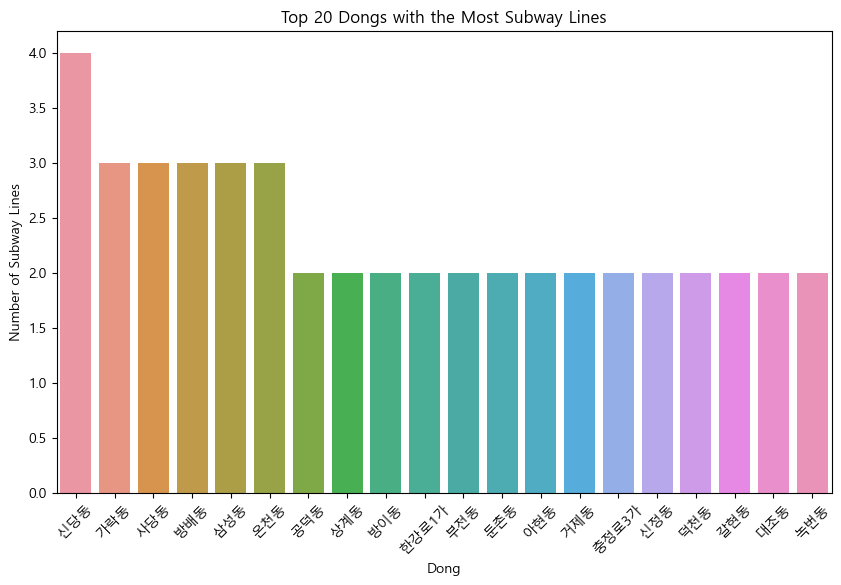

In [209]:
#각 동에서 얼마나 많은 지하철 호선이 있는지
dong_line_counts = subway_total['dong'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=dong_line_counts.index, y=dong_line_counts.values)
plt.title('Top 20 Dongs with the Most Subway Lines')
plt.xlabel('Dong')
plt.ylabel('Number of Subway Lines')
plt.xticks(rotation=45)
plt.show()

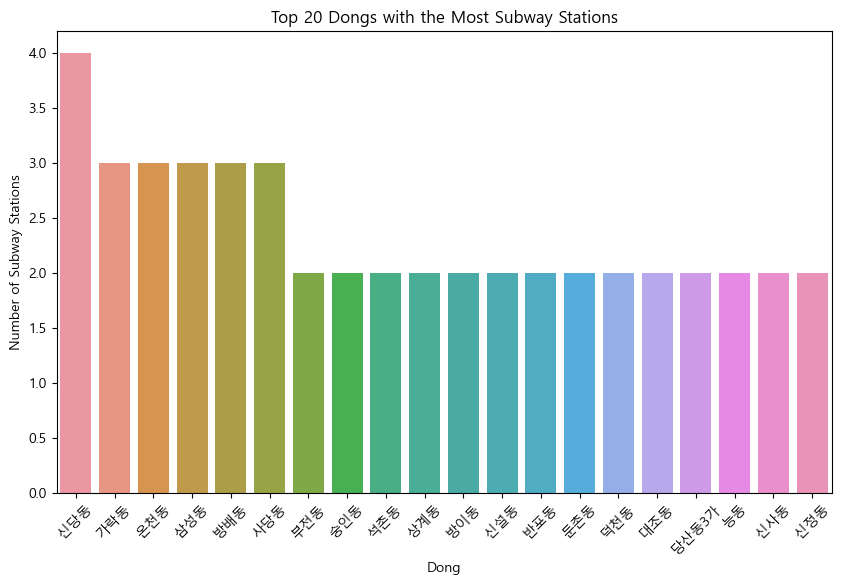

In [210]:
#각 동에서 얼마나 많은 지하철 역이 있는지
station_counts = subway_total.groupby('dong').size().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=station_counts.index, y=station_counts.values)
plt.title('Top 20 Dongs with the Most Subway Stations')
plt.xlabel('Dong')
plt.ylabel('Number of Subway Stations')
plt.xticks(rotation=45)
plt.show()

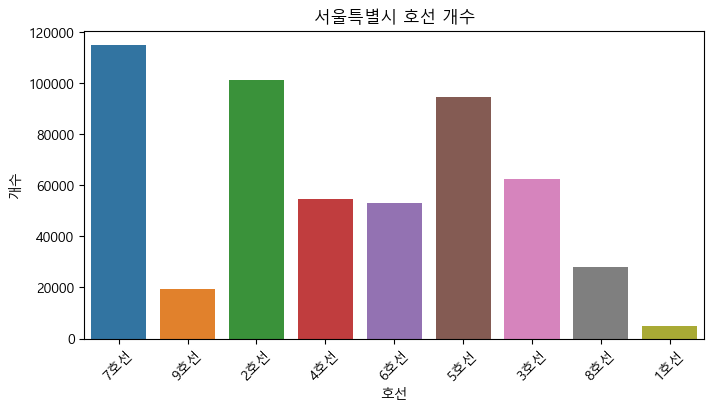

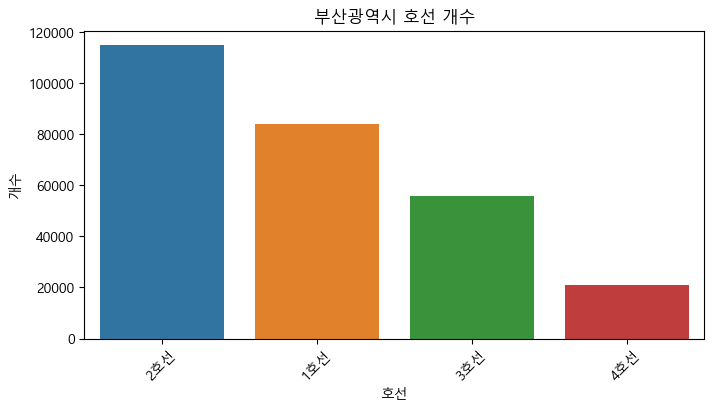

In [211]:
# 서울과 부산 데이터 분리
seoul_data = train_df[train_df['city'] == '서울특별시']
busan_data = train_df[train_df['city'] == '부산광역시']

# 서울 데이터 시각화
plt.figure(figsize=(8,4))
sns.countplot(x='호선', data=seoul_data)
plt.title('서울특별시 호선 개수')
plt.xlabel('호선')
plt.ylabel('개수')
plt.xticks(rotation=45)
plt.show()

# 부산 데이터 시각화
plt.figure(figsize=(8,4))
sns.countplot(x='호선', data=busan_data)
plt.title('부산광역시 호선 개수')
plt.xlabel('호선')
plt.ylabel('개수')
plt.xticks(rotation=45)
plt.show()

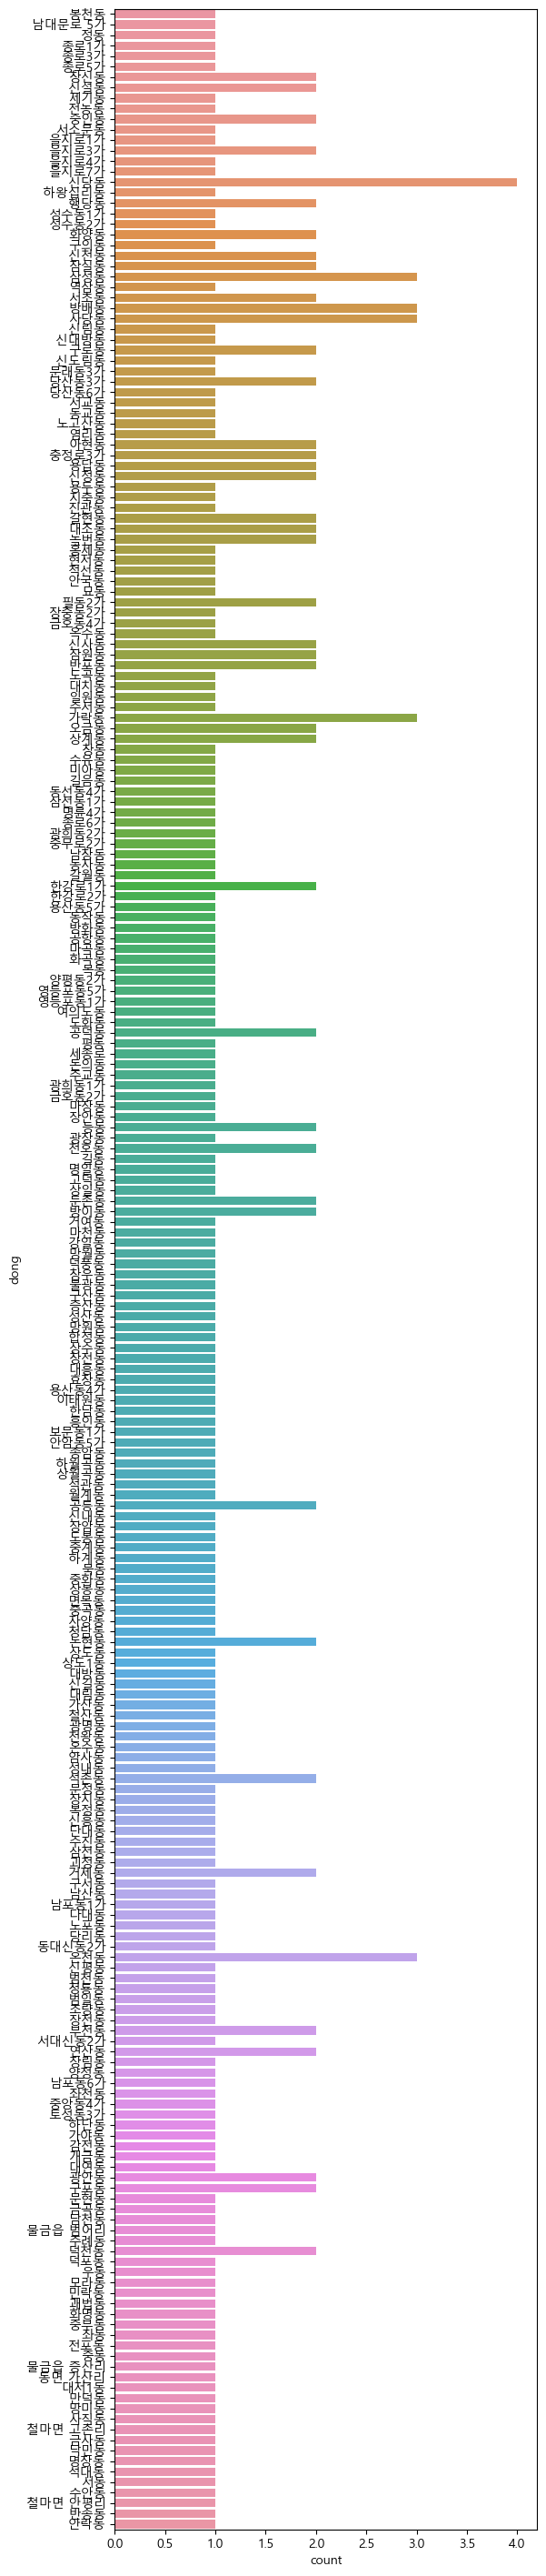

In [212]:
#'dong' 열에 대해 각 동의 비율
plt.figure(figsize=(6, 36))  
sns.countplot(y='dong', data=subway_total)  
plt.show() 

In [213]:
test_df.drop_duplicates(subset='transaction_id', keep='first', inplace=True)

In [214]:
test_df = test_df.drop([ 'transaction_id'],axis=1)

    병원

In [215]:
## 부산 ##
pu_hos = pu_hos[pu_hos['영업상태명'] != '폐업']
pu_hos = pu_hos[pu_hos['영업상태명'] != '취소/말소/만료/정지/중지']
pu_hos = pu_hos[pu_hos['영업상태명'] != '휴업']

pu_hos.drop(pu_hos.columns[0:19], axis=1, inplace=True)
pu_hos.drop(pu_hos.columns[1:], axis=1, inplace=True)

pu_hos['dong'] = pu_hos['도로명전체주소'].str.extract(r'\((.*?)\)', expand=False)
pu_hos['dong'] = pu_hos['dong'].str.split(',').str[0]
pu_hos = pu_hos.rename(columns={'도로명전체주소': '주소'})

## 서울 ##
se_hos.drop(se_hos.columns[0:1], axis=1, inplace=True)
se_hos.drop(se_hos.columns[1:], axis=1, inplace=True)

se_hos['dong'] = se_hos['주소'].str.extract(r'\((.*?)\)', expand=False)
se_hos['dong'] = se_hos['dong'].str.split(',').str[0]

## 병원 전체병합 ##
hos_total = pd.concat([se_hos, pu_hos], axis=0, ignore_index=True)



## train, test에 병합 ##
hos_counts_dict = hos_total['dong'].value_counts().to_dict()
train_df['hos_dongs_count'] = train_df['dong'].map(hos_counts_dict)
test_df['hos_dongs_count'] = test_df['dong'].map(hos_counts_dict)

###############################################################################




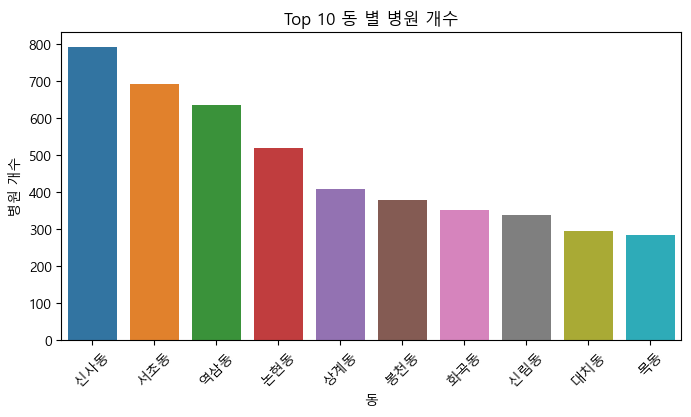

In [216]:
top_dongs = hos_total['dong'].value_counts().head(10).index # 병원 개수 상위 10개 동 선택

top_dong_data = hos_total[hos_total['dong'].isin(top_dongs)]

plt.figure(figsize=(8, 4))
sns.countplot(x='dong', data=top_dong_data, order = top_dong_data['dong'].value_counts().index)
plt.title('Top 10 동 별 병원 개수')
plt.xlabel('동')
plt.ylabel('병원 개수')
plt.xticks(rotation=45)
plt.show()

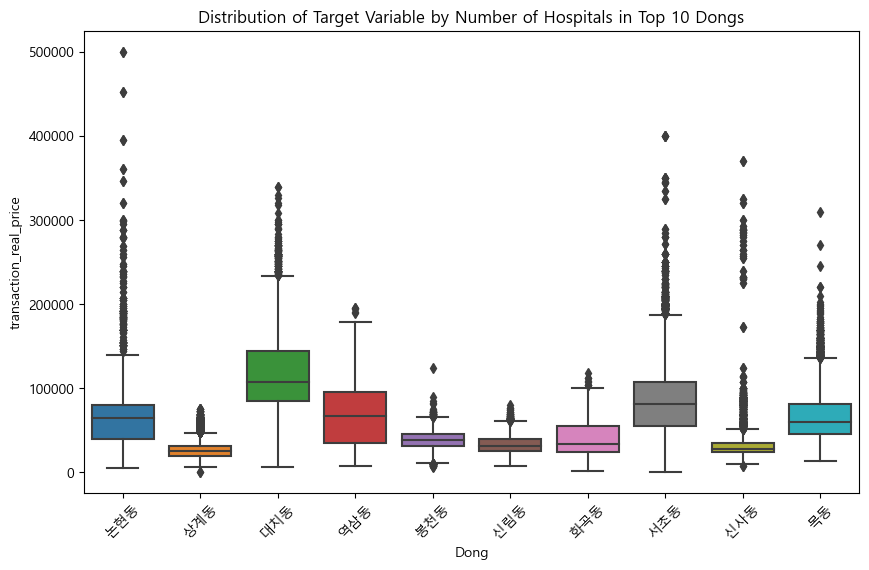

In [217]:
#병원 수 상위 10개 동에 대한 타겟 변수 분포
top10_dongs = hos_total['dong'].value_counts().index[:10]  
top10_train_df = train_df[train_df['dong'].isin(top10_dongs)] 

plt.figure(figsize=(10, 6))
sns.boxplot(x=top10_train_df['dong'], y=top10_train_df['transaction_real_price'])
plt.title('Distribution of Target Variable by Number of Hospitals in Top 10 Dongs')
plt.xlabel('Dong')
plt.ylabel('transaction_real_price')
plt.xticks(rotation=45)  
plt.show()

    학원

In [218]:
pu_gyo = pu_gyo.rename(columns={'교습소명': '학원명'}) # 컬럼명 바꾸기

pu_total = pd.concat([pu_aca, pu_gyo], axis=0, ignore_index=True) # 과목별 학원 병합
pu_total.drop(pu_total.columns[0:4], axis=1, inplace=True)
pu_total.drop(pu_total.columns[1:], axis=1, inplace=True)
pu_total['dong'] = pu_total['위치'].str.extract(r'\((.*?)\)', expand=False)
pu_total['dong'] = pu_total['dong'].str.split(',').str[0]


se_aca.drop(se_aca.columns[0:5], axis=1, inplace=True)
se_aca.drop(se_aca.columns[1:], axis=1, inplace=True)
se_aca['dong'] = se_aca['도로명상세주소'].str.extract(r'\((.*?)\)', expand=False)
se_aca['dong'] = se_aca['dong'].str.split(',').str[0]
se_aca = se_aca.rename(columns={'도로명상세주소': '위치'})

aca_total = pd.concat([pu_total, se_aca], axis=0, ignore_index=True)


## train, test에 병합 ##
aca_counts_dict = aca_total['dong'].value_counts().to_dict()
train_df['aca_dongs_count'] = train_df['dong'].map(aca_counts_dict)
test_df['aca_dongs_count'] = test_df['dong'].map(aca_counts_dict)

###############################################################################





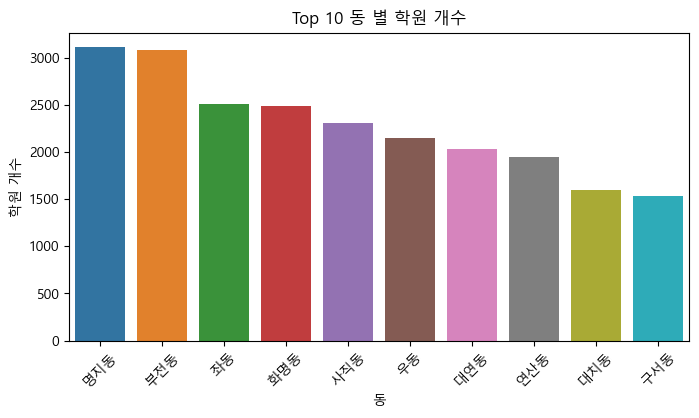

In [219]:
top_dongs = aca_total['dong'].value_counts().head(10).index # 학원 개수 상위 10개 동 선택

top_dong_data = aca_total[aca_total['dong'].isin(top_dongs)]

plt.figure(figsize=(8, 4))
sns.countplot(x='dong', data=top_dong_data, order = top_dong_data['dong'].value_counts().index)
plt.title('Top 10 동 별 학원 개수')
plt.xlabel('동')
plt.ylabel('학원 개수')
plt.xticks(rotation=45)
plt.show()

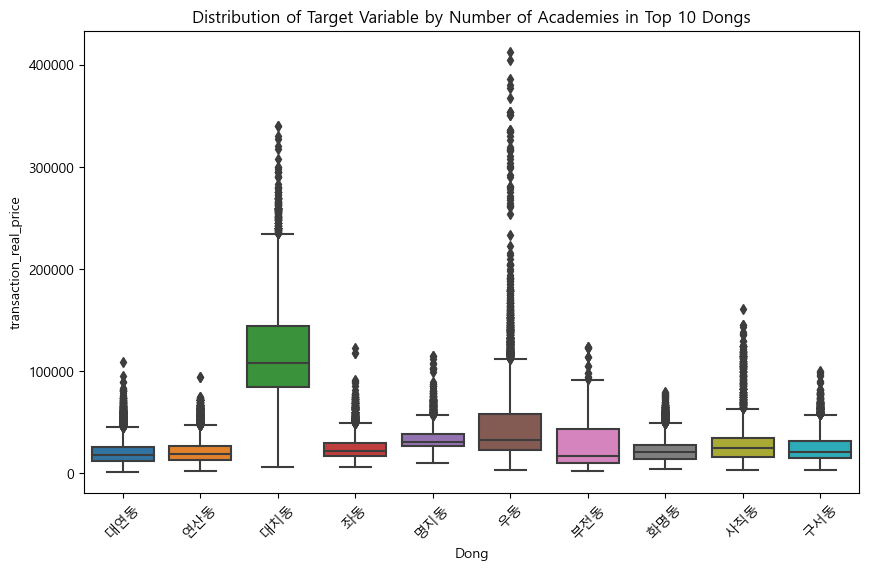

In [220]:
#학원 수 상위 10개 동에 대한 타겟 변수 분포
top10_dongs = aca_total['dong'].value_counts().index[:10]  
top10_train_df = train_df[train_df['dong'].isin(top10_dongs)]  

plt.figure(figsize=(10, 6))
sns.boxplot(x=top10_train_df['dong'], y=top10_train_df['transaction_real_price'])
plt.title('Distribution of Target Variable by Number of Academies in Top 10 Dongs')
plt.xlabel('Dong')
plt.ylabel('transaction_real_price')
plt.xticks(rotation=45)  
plt.show()

    공원

In [221]:
park_df.head()

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,NaN,NaN,NaN,NaN,NaN,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,NaN,NaN,NaN,NaN,NaN,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,NaN,NaN,NaN,NaN,NaN,1970.0,2018-08-14


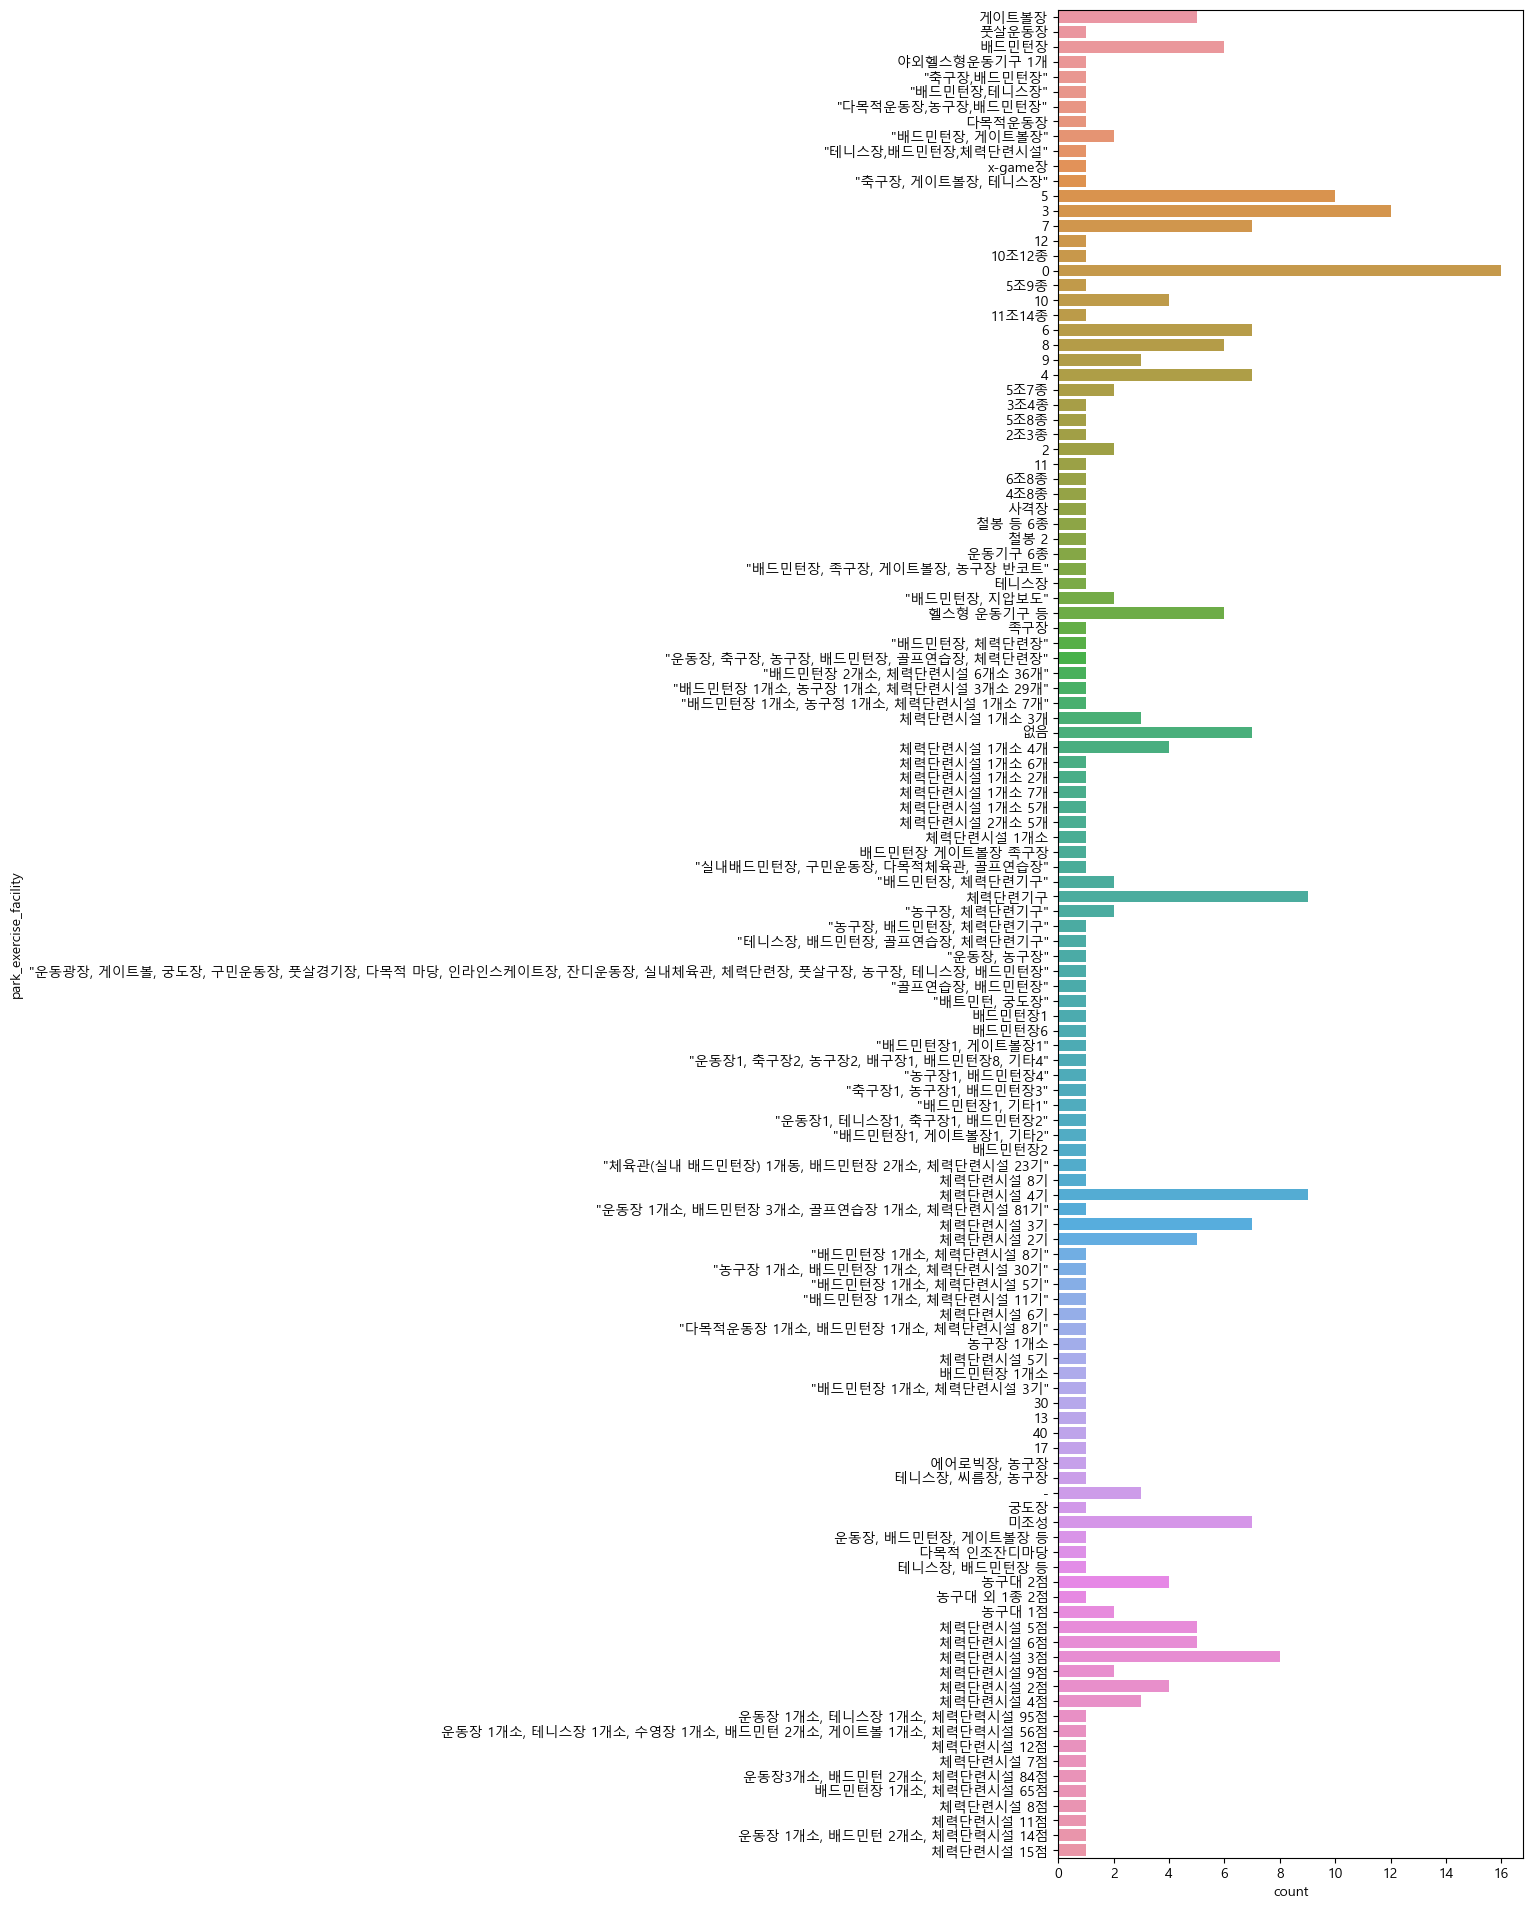

In [222]:
plt.figure(figsize=(6, 24))

sns.countplot(y='park_exercise_facility', data=park_df)

plt.show()

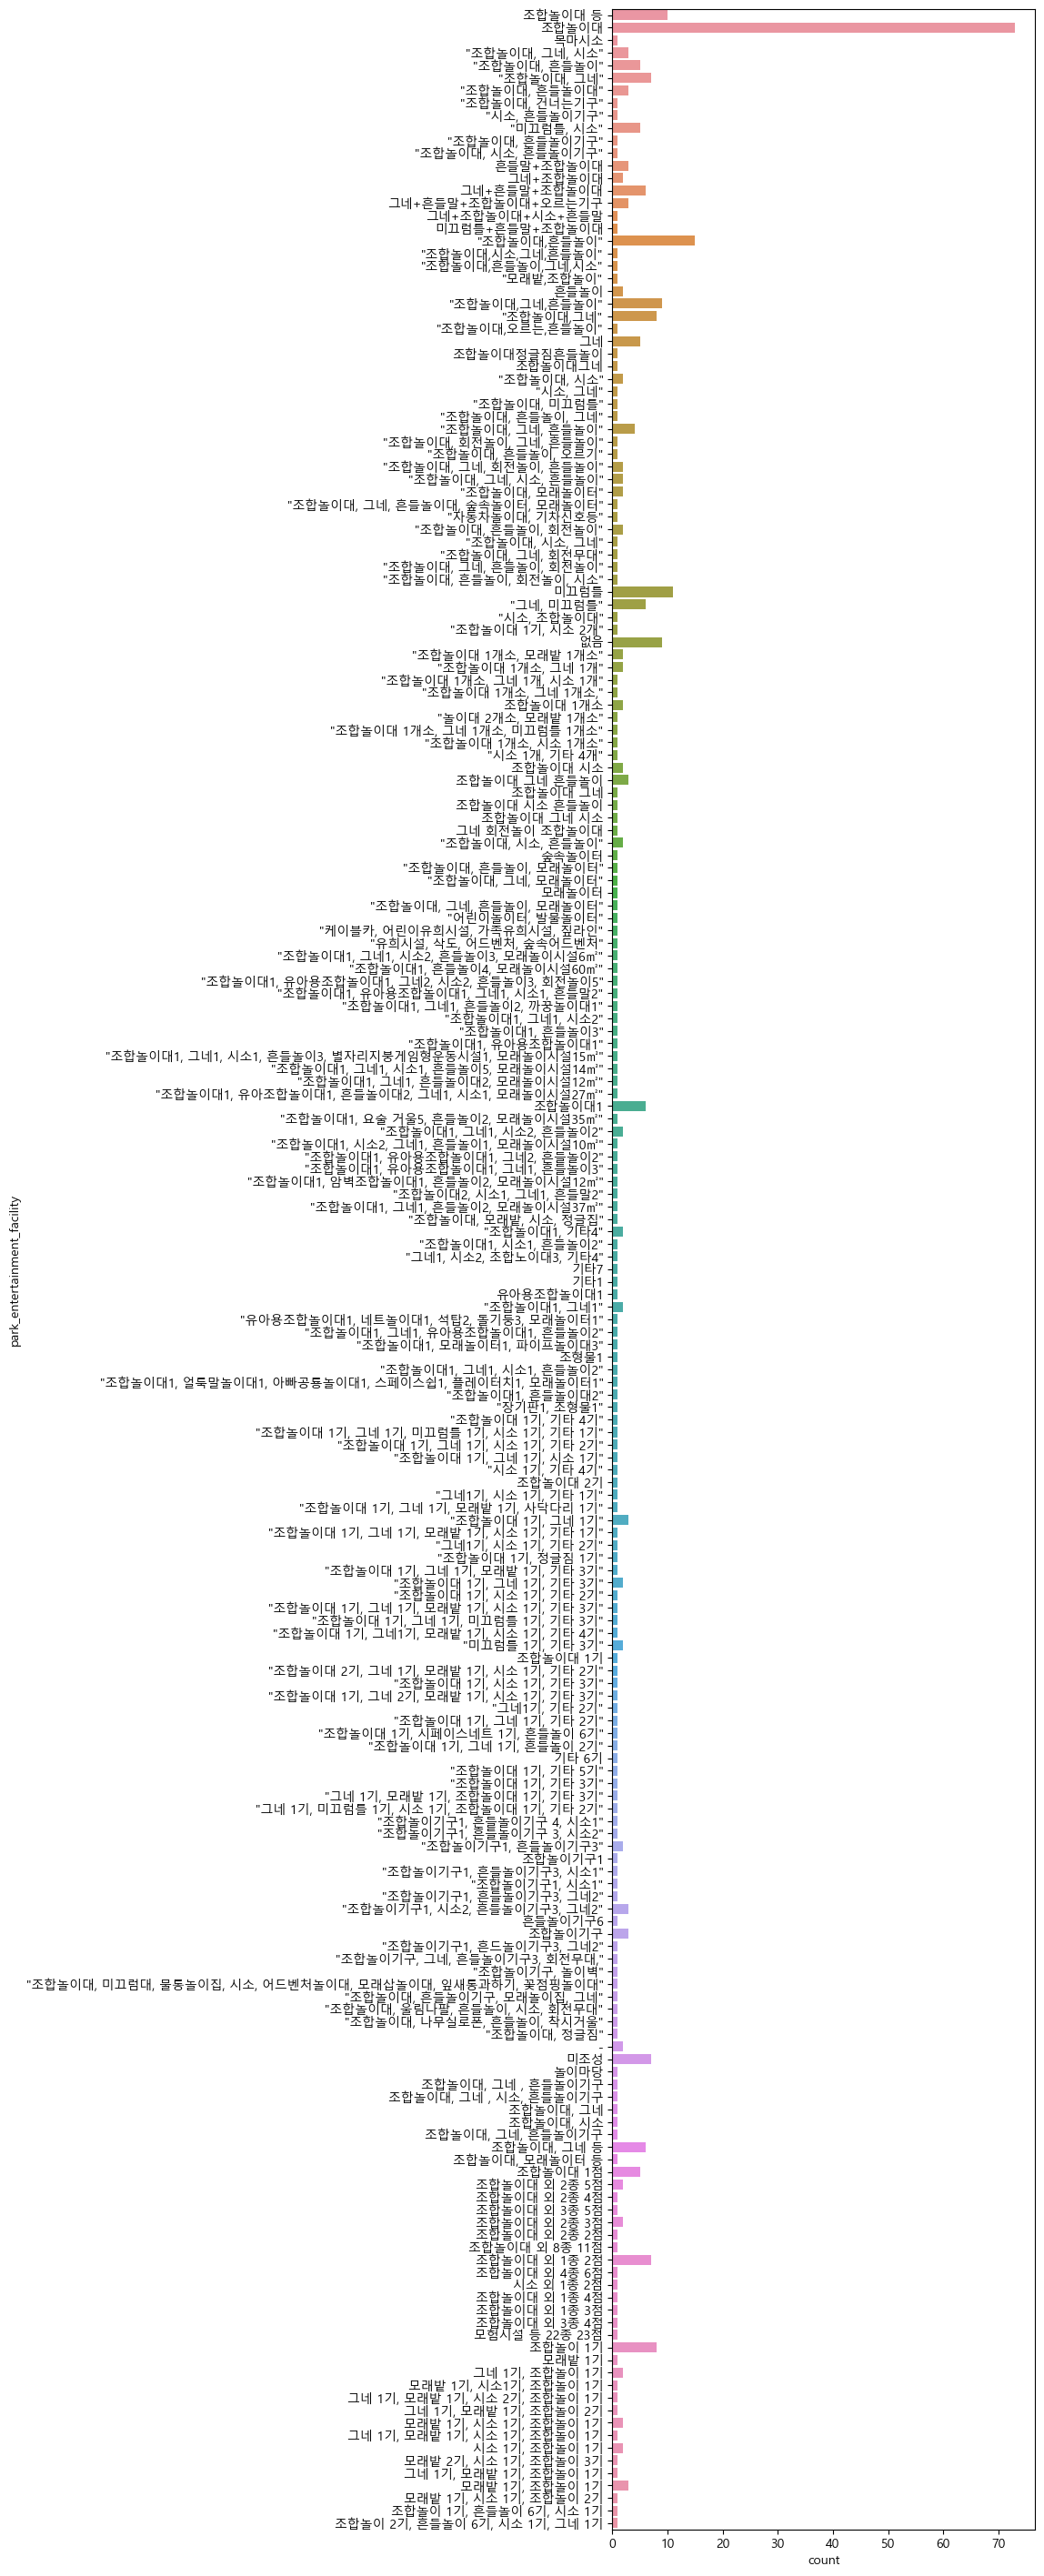

In [223]:
plt.figure(figsize=(6, 36))

sns.countplot(y='park_entertainment_facility', data=park_df)

plt.show()

In [224]:
park_df.at[565,'gu'] = '중구'
park_df.at[566,'gu'] = '부산진구'
park_df.at[567,'gu'] = '동래구'


###############################################################################


# 'transaction_year_month' 열의 고유한 값들을 오름차순으로 정렬
sorted_unique_values = sorted(train_df['transaction_year_month'].unique())
mapping_dict = {value: index + 1 for index, value in enumerate(sorted_unique_values)}
train_df['transaction_year_month_sort'] = train_df['transaction_year_month'].map(mapping_dict)

sorted_unique_values = sorted(test_df['transaction_year_month'].unique())
mapping_dict = {value: index + 1 for index, value in enumerate(sorted_unique_values)}
test_df['transaction_year_month_sort'] = test_df['transaction_year_month'].map(mapping_dict)

# 해당작업 후 제거
test_df = test_df.drop(['transaction_year_month'],axis=1)
train_df = train_df.drop(['transaction_year_month'],axis=1)

################################################################################

#care_df에는 동대문구, 용산구가 없다.

park_care_df = pd.merge(park_df, care_df, on='gu', how='left')

train_df['dong_park_count'] = train_df['dong'].map(park_care_df.groupby('dong')['park_name'].count())
test_df['dong_park_count'] = test_df['dong'].map(park_care_df.groupby('dong')['park_name'].count())

train_df['dong_park_area_mean'] = train_df['dong'].map(park_care_df.groupby('dong')['park_area'].mean())
test_df['dong_park_area_mean'] = test_df['dong'].map(park_care_df.groupby('dong')['park_area'].mean())

train_df['park_type_count'] = train_df['dong'].map(park_care_df.groupby('dong')['park_type'].count())
test_df['park_type_count'] = test_df['dong'].map(park_care_df.groupby('dong')['park_type'].count())

    약국

In [225]:
phar.head()

,암호화요양기호,요양기관명,종별코드,종별코드명,시도코드,시도코드명,시군구코드,시군구코드명,읍면동,우편번호,주소,전화번호,개설일자,x좌표,y좌표
0,JDQ4MTAxMiM1MSMkMSMkMCMkMDMkMzgxMTkxIzQxIyQxIy...,동원약국,81,약국,210000,부산,210004,부산진구,NaN,47221.0,부산광역시 부산진구 진남로 551 1층 (양정동),051-853-4101,2009-12-08,129.075790,35.170131
1,JDQ4MTAxMiM1MSMkMSMkMCMkMDMkMzgxMzUxIzUxIyQxIy...,대지약국,81,약국,210000,부산,210010,부산사하구,감천동,49369.0,부산광역시 사하구 옥천로 37 (감천동),051-203-9764,1984-01-30,129.006510,35.090818
2,JDQ4MTAxMiM1MSMkMSMkMCMkMDMkMzgxOTYxIzQxIyQyIy...,대학온누리약국,81,약국,210000,부산,210001,부산남구,대연동,48434.0,부산광역시 남구 수영로 299 (대연동),051-622-6421,2014-10-01,129.098875,35.137167
3,JDQ4MTAxMiM1MSMkMSMkMCMkMDMkMzgxOTYxIzIxIyQxIy...,참진약국,81,약국,210000,부산,210004,부산진구,범천동,47365.0,부산광역시 부산진구 범일로 146-1 (범천동),051-637-4714,2015-05-12,129.059576,35.143104
4,JDQ4MTAxMiM1MSMkMSMkMCMkMDMkMzgxMTkxIzQxIyQxIy...,새동래약국,81,약국,210000,부산,210003,부산동래구,수안동,47814.0,부산광역시 동래구 명륜로98번길 10 (수안동),051-555-6933,2008-09-16,129.083926,35.202528


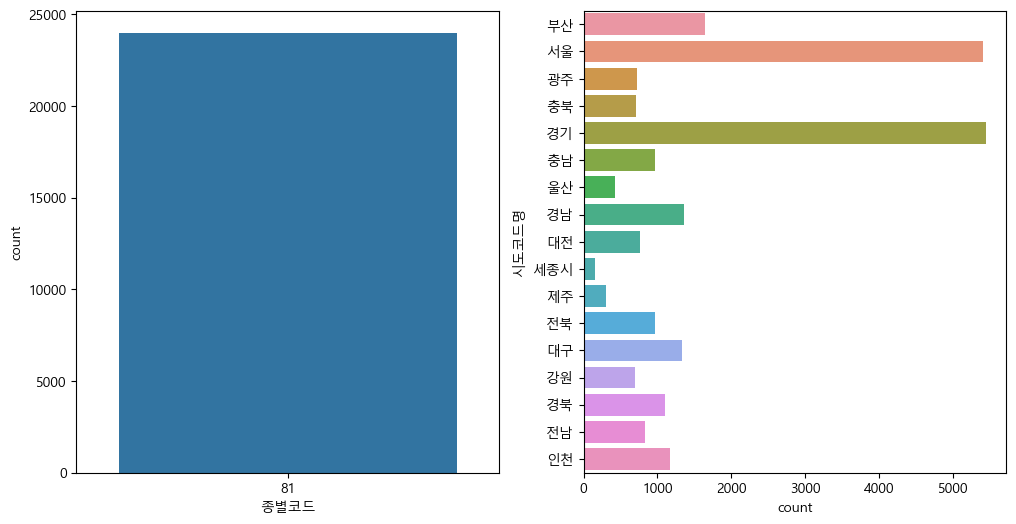

In [226]:
plt.figure(figsize=(12, 6))

# subplot
plt.subplot(1, 2, 1)

# Countplot
sns.countplot(x='종별코드', data=phar)

# subplot
plt.subplot(1, 2, 2)

# Countplot
sns.countplot(y='시도코드명', data=phar) 

plt.show()

# 가치없는 열들과 필요한 열들을 분류.

In [227]:
phar.drop(phar.columns[0:5], axis=1, inplace=True)
phar.drop(phar.columns[4:], axis=1, inplace=True)

시도코드명 = ['서울', '부산']
phar = phar[phar['시도코드명'].isin(시도코드명)]

phar.dropna(subset=['읍면동'], inplace=True)

## train, test에 병합 ##
phar_counts_dict = phar['읍면동'].value_counts().to_dict()
train_df['phar_counts_count'] = train_df['dong'].map(phar_counts_dict)
test_df['phar_counts_count'] = test_df['dong'].map(phar_counts_dict)

###############################################################################




    상권

In [228]:
pu_mar.head(3)

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,MA0101202210A0072343,선해횟집,NaN,I2,음식,I201,한식,I20111,횟집,I56111,한식 일반 음식점업,26,부산광역시,26410,금정구,26410555,금사회동동,2641011100,금사동,2641011100100300027,1,대지,30.0,27.0,부산광역시 금정구 금사동 30-27,264104205209,부산광역시 금정구 사천로3번길,2,NaN,2641011100100300027023409,NaN,부산광역시 금정구 사천로3번길 2,609808,46264,NaN,1,NaN,129.113321,35.223363
1,MA010120220805430802,미즈노,NaN,G2,소매,G209,섬유·의복·신발 소매,G20905,기타 의류 소매업,G47419,기타 의복 소매업,26,부산광역시,26350,해운대구,26350520,우2동,2635010500,우동,2635010500114960000,1,대지,1496.0,NaN,부산광역시 해운대구 우동 1496,263502133001,부산광역시 해운대구 센텀남대로,59,NaN,2635010500114960000000001,롯데백화점센텀시티점,부산광역시 해운대구 센텀남대로 59,612022,48058,NaN,5,NaN,129.131099,35.169873
2,MA010120220805430814,리스트,NaN,G2,소매,G209,섬유·의복·신발 소매,G20902,여성 의류 소매업,G47412,여자용 겉옷 소매업,26,부산광역시,26440,강서구,26440535,명지1동,2644010400,명지동,2644010400134380000,1,대지,3438.0,NaN,부산광역시 강서구 명지동 3438,264403350859,부산광역시 강서구 명지국제6로,168,NaN,2644010400134380000000001,스타필드시티명지점,부산광역시 강서구 명지국제6로 168,618200,46772,NaN,2,NaN,128.918174,35.093125


In [229]:
se_mar.head(3)

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,MA0101202210A0037544,영자's곱창,NaN,I2,음식,I201,한식,I20109,곱창 전골/구이,I56111,한식 일반 음식점업,11,서울특별시,11215,광진구,11215760,중곡3동,1121510100,중곡동,1121510100101690021,1,대지,169,21.0,서울특별시 광진구 중곡동 169-21,112153005027,서울특별시 광진구 면목로,172.0,NaN,1121510100101690021003140,NaN,서울특별시 광진구 면목로 172,143900,4904,NaN,1,NaN,127.082832,37.568503
1,MA0101202210A0097916,호텔클로이,NaN,I1,숙박,I101,일반 숙박,I10102,여관/모텔,I55102,여관업,11,서울특별시,11140,중구,11140590,광희동,1114014500,광희동1가,1114014500101300000,1,대지,130,NaN,서울특별시 중구 광희동1가 130,111404103258,서울특별시 중구 을지로42길,11.0,NaN,1114014500101300000014092,유성장,서울특별시 중구 을지로42길 11,100411,4561,NaN,NaN,NaN,127.005849,37.565708
2,MA0101202210A0096343,나라차중계태권도장,NaN,P1,교육,P106,기타 교육,P10601,태권도/무술학원,P85611,태권도 및 무술 교육기관,11,서울특별시,11350,노원구,11350619,중계본동,1135010600,중계동,1135010600103640019,1,대지,364,19.0,서울특별시 노원구 중계동 364-19,113503110009,서울특별시 노원구 한글비석로,242.0,NaN,1135010600103640019010971,삼부프라자,서울특별시 노원구 한글비석로 242,139861,1734,NaN,NaN,NaN,127.076956,37.649226


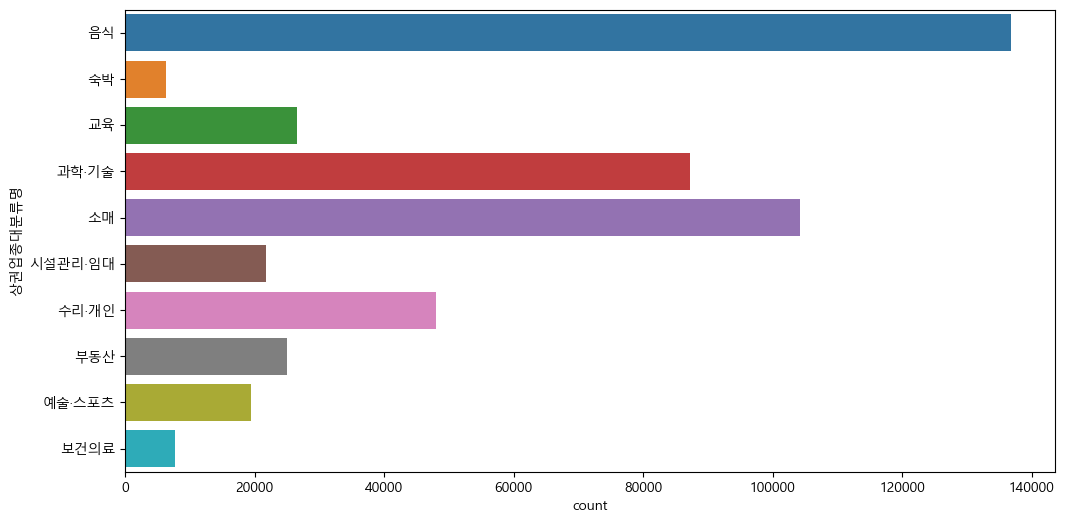

In [230]:
plt.figure(figsize=(12, 6))

sns.countplot(y='상권업종대분류명', data=se_mar)

plt.show()

In [231]:
mar_total = pd.concat([se_mar, pu_mar], axis=0, ignore_index=True)

## train, test에 병합 ##
mar_counts_dict = mar_total['법정동명'].value_counts().to_dict()
train_df['mar_counts_count'] = train_df['dong'].map(mar_counts_dict)
test_df['mar_counts_count'] = test_df['dong'].map(mar_counts_dict)

major_industry_by_dong = mar_total.groupby('법정동명')['상권업종대분류명'].agg(lambda x: x.value_counts().idxmax())
train_df['major_industry'] = train_df['dong'].map(major_industry_by_dong)
test_df['major_industry'] = test_df['dong'].map(major_industry_by_dong)
###############################################################################




    care

In [232]:
care_df.head()

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle,reference_date
0,서울특별시,서대문구,가람어린이집,국공립,70,11.0,5.0,1.0,7.0,N,2018-07-31
1,서울특별시,서대문구,가좌제일어린이집,국공립,88,22.0,5.0,2.0,10.0,N,2018-07-31
2,서울특별시,서대문구,경찰청어린이집,직장,90,23.0,6.0,1.0,32.0,N,2018-07-31
3,서울특별시,서대문구,고운햇살어린이집,가정,18,5.0,3.0,0.0,4.0,N,2018-07-31
4,서울특별시,서대문구,고은어린이집,국공립,93,20.0,7.0,2.0,10.0,N,2018-07-31


In [233]:
care_se = care_se.iloc[:, :7]
columns_to_drop = ['어린이집코드', '운영현황', '우편번호']
care_se = care_se.drop(columns=columns_to_drop)
care_se = care_se.rename(columns={'시군구명': 'gu', '어린이집명': 'day_care_name', '어린이집유형': 'day_care_type', '상세주소':'add'})

care_pu = care_pu.iloc[:, :7]
columns_to_drop = ['시도명', '정원수', '보육교직원수']
care_pu = care_pu.drop(columns=columns_to_drop)
care_pu = care_pu.rename(columns={'시군구명': 'gu', '어린이집명': 'day_care_name', '어린이집유형구분': 'day_care_type', '소재지도로명주소':'add'})
new_order = ['gu', 'day_care_name', 'day_care_type', 'add']
care_pu = care_pu[new_order]

sungdong = sungdong.iloc[:, :7]
columns_to_drop = ['어린이집코드', '운영현황', '우편번호']
sungdong = sungdong.drop(columns=columns_to_drop)
sungdong = sungdong.rename(columns={'시군구명': 'gu', '어린이집명': 'day_care_name', '어린이집유형': 'day_care_type', '상세주소':'add'})
sungdong['day_care_name'] = sungdong['day_care_name'].str.replace('어린이집', '')

care_se_total = pd.concat([care_se, sungdong], ignore_index=True)
care_sub = pd.concat([care_se_total, care_pu], ignore_index=True)

care_total = pd.merge(care_df, care_sub, on=['gu', 'day_care_name', 'day_care_type'], how='left')
care_total['add'] = care_total['add'].fillna('null')
care_total.drop(care_total.columns[4:11], axis=1, inplace=True)

care_total['dong'] = care_total['add'].str.extract(r'\((.*?)\)', expand=False)
care_total['dong'] = care_total['dong'].str.split(',').str[0]
care_total['dong'] = care_total['dong'].str.extract(r'([^\d]+)')

## train, test에 병합 ##
care_counts_dict = care_total['dong'].value_counts().to_dict()
train_df['care_counts_count'] = train_df['dong'].map(care_counts_dict)
test_df['care_counts_count'] = test_df['dong'].map(care_counts_dict)

major_care = care_total.groupby('dong')['day_care_type'].agg(lambda x: x.value_counts().idxmax())
train_df['major_care'] = train_df['dong'].map(major_care)
test_df['major_care'] = test_df['dong'].map(major_care)
###############################################################################




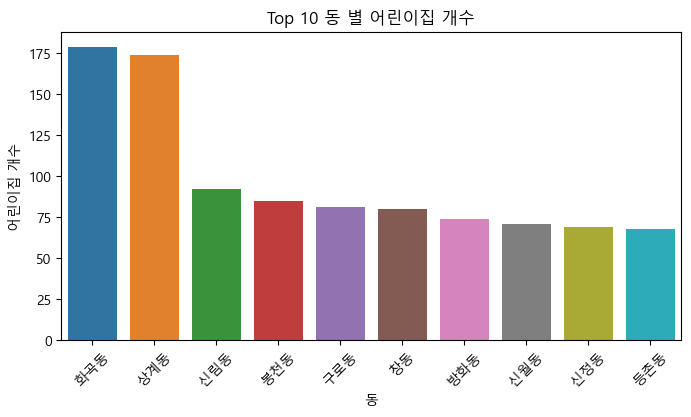

In [234]:
top_dongs = care_total['dong'].value_counts().head(10).index # 어린이집 개수 상위 10개 동 선택

top_dong_data = care_total[care_total['dong'].isin(top_dongs)]

plt.figure(figsize=(8, 4))
sns.countplot(x='dong', data=top_dong_data, order = top_dong_data['dong'].value_counts().index)
plt.title('Top 10 동 별 어린이집 개수')
plt.xlabel('동')
plt.ylabel('어린이집 개수')
plt.xticks(rotation=45)
plt.show()

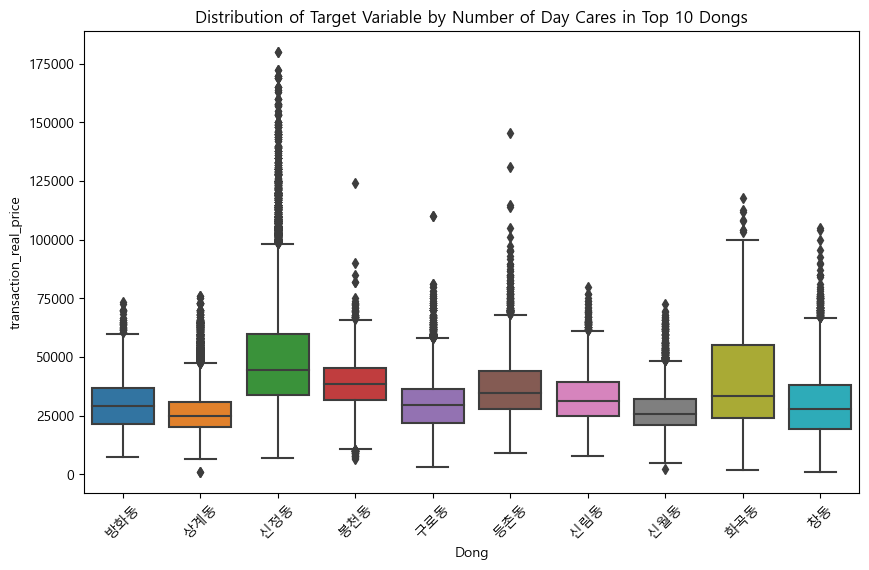

In [235]:
top10_dongs = care_total['dong'].value_counts().index[:10]
top10_train_df = train_df[train_df['dong'].isin(top10_dongs)]

plt.figure(figsize=(10, 6))
sns.boxplot(x=top10_train_df['dong'], y=top10_train_df['transaction_real_price'])
plt.title('Distribution of Target Variable by Number of Day Cares in Top 10 Dongs')
plt.xlabel('Dong')
plt.ylabel('transaction_real_price')
plt.xticks(rotation=45)
plt.show()

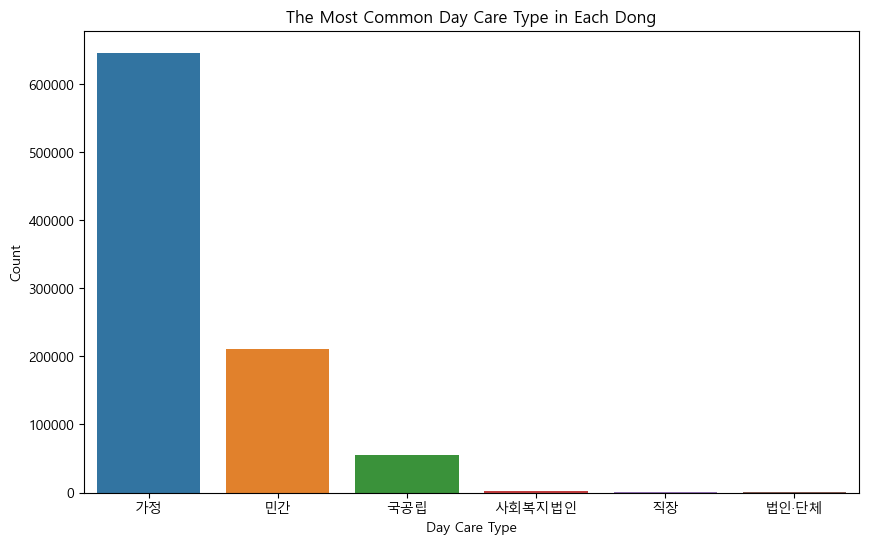

In [236]:
#각 동의 주요 어린이집 유형 
major_care_counts = train_df['major_care'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=major_care_counts.index, y=major_care_counts.values)
plt.title('The Most Common Day Care Type in Each Dong')
plt.xlabel('Day Care Type')
plt.ylabel('Count')
plt.show()

# 2. 결측치 처리

In [237]:
train_df.head()

,city,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,average_price,호선,count,hos_dongs_count,aca_dongs_count,transaction_year_month_sort,dong_park_count,dong_park_area_mean,park_type_count,phar_counts_count,mar_counts_count,major_industry,care_counts_count,major_care
0,부산광역시,서대신동3가,112.24,2001,3,5,23500,21900,NaN,NaN,1.0,424.0,69,80.0,1.052418e+06,80.0,8.0,409.0,음식,NaN,NaN
1,부산광역시,대연동,59.99,1997,3,7,17000,17500,2호선,3.0,10.0,2032.0,106,2145.0,2.743887e+04,2145.0,22.0,4516.0,음식,30.0,가정
2,부산광역시,서대신동2가,60.26,1976,3,5,7500,19000,1호선,1.0,1.0,143.0,48,NaN,NaN,NaN,3.0,291.0,음식,NaN,NaN
3,서울특별시,논현동,84.94,2004,3,8,62500,65000,7호선,2.0,519.0,185.0,41,2007.0,4.506133e+03,2007.0,30.0,9548.0,과학·기술,2.0,민간
4,서울특별시,논현동,84.94,2004,3,8,62500,65000,9호선,1.0,519.0,185.0,41,2007.0,4.506133e+03,2007.0,30.0,9548.0,과학·기술,2.0,민간


In [238]:
# 0이라고 판단되는 것들이라서 0으로 처리.
train_df['호선'] = train_df['호선'].fillna('null')
train_df['count'] = train_df['count'].fillna(0)
train_df['dong_park_count'] = train_df['dong_park_count'].fillna(0)
train_df['hos_dongs_count'] = train_df['hos_dongs_count'].fillna(0)
train_df['aca_dongs_count'] = train_df['aca_dongs_count'].fillna(0)
train_df['phar_counts_count'] = train_df['phar_counts_count'].fillna(0)
train_df['mar_counts_count'] = train_df['mar_counts_count'].fillna(0)
train_df['major_industry'] = train_df['major_industry'].fillna('null')
train_df['care_counts_count'] = train_df['care_counts_count'].fillna(0)
train_df['major_care'] = train_df['major_care'].fillna('null')
train_df['dong_park_area_mean'] = train_df['dong_park_area_mean'].fillna(0)
train_df['park_type_count'] = train_df['park_type_count'].fillna(0)
# test_df 열 처리
test_df['호선'] = test_df['호선'].fillna('null')
test_df['count'] = test_df['count'].fillna(0)
test_df['dong_park_count'] = test_df['dong_park_count'].fillna(0)
test_df['hos_dongs_count'] = test_df['hos_dongs_count'].fillna(0)
test_df['aca_dongs_count'] = test_df['aca_dongs_count'].fillna(0)
test_df['phar_counts_count'] = test_df['phar_counts_count'].fillna(0)
test_df['mar_counts_count'] = test_df['mar_counts_count'].fillna(0)
test_df['major_industry'] = test_df['major_industry'].fillna('null')
test_df['care_counts_count'] = test_df['care_counts_count'].fillna(0)
test_df['major_care'] = test_df['major_care'].fillna('null')
test_df['dong_park_area_mean'] = test_df['dong_park_area_mean'].fillna(0)
test_df['park_type_count'] = test_df['park_type_count'].fillna(0)

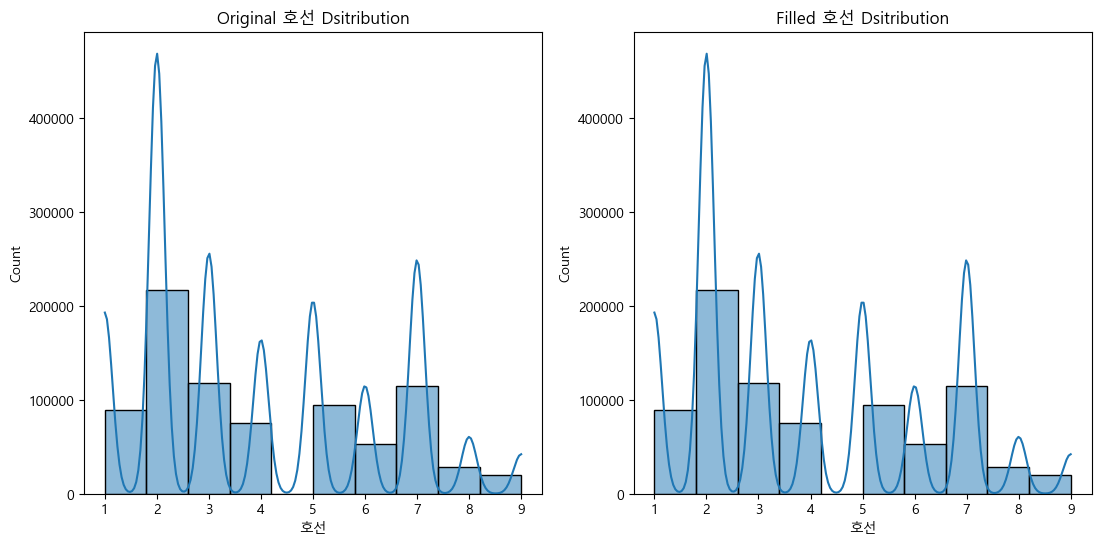

In [239]:
# 결측치 처리 전과 결측치 처리 후의 분포를 비교
fig, axes = plt.subplots(1,2, figsize = (13, 6))

train_df_before = train_df.copy()

train_df_before['호선'] = train_df_before['호선'].astype(str).str.extract('(\d+)').astype(float) # 호선 데이터에서 숫자만 추출
train_df['호선'] = train_df['호선'].astype(str).str.extract('(\d+)').astype(float)

sns.histplot(data = train_df_before, x = '호선', ax = axes[0], bins=10, kde = True)
sns.histplot(data = train_df, x = '호선', ax = axes[1], bins=10, kde = True)

axes[0].set_title('Original 호선 Dsitribution')
axes[1].set_title('Filled 호선 Dsitribution')
plt.show()

In [240]:
y = train_df['transaction_real_price']
train_df = train_df.drop('transaction_real_price', axis=1)

In [241]:
# test_df의 9호선이 너무 적어서 pca는 9호선 제외하고 진행.
train_df['호선_org'] = train_df['호선'].copy()
test_df['호선_org'] = test_df['호선'].copy()
train_df['호선'].replace('9호선', 'null', inplace=True)
test_df['호선'].replace('9호선', 'null', inplace=True)

In [242]:

# train_df 데이터프레임에 대한 One-Hot 인코딩
encoder = OneHotEncoder(sparse=False)
encoded_data_train = encoder.fit_transform(train_df[['호선']])

# PCA 적용
max_d_train = num_d_train = encoded_data_train.shape[1]
pca_train = PCA(n_components=max_d_train).fit(encoded_data_train)
cumsum_train = np.cumsum(pca_train.explained_variance_ratio_) 
num_d_train = np.argmax(cumsum_train >= 0.99) + 1             
if num_d_train == 1: num_d_train = max_d_train
pca_train = PCA(n_components=num_d_train, random_state=0)  
train_df_pca = pca_train.fit_transform(encoded_data_train)

# 새로운 열 추가
train_df_pca_columns = [f'호선_onehot_PCA_{i+1}' for i in range(num_d_train)]
train_df[train_df_pca_columns] = train_df_pca


# train_df의 "호선" 열 삭제
train_df.drop("호선", axis=1, inplace=True)


In [243]:
encoder = OneHotEncoder(sparse=False)
encoded_data_test = encoder.fit_transform(test_df[['호선']])

# PCA 적용
max_d_test = num_d_test = encoded_data_test.shape[1]
pca_test = PCA(n_components=max_d_test).fit(encoded_data_test)
cumsum_test = np.cumsum(pca_test.explained_variance_ratio_) 
num_d_test = np.argmax(cumsum_test >= 0.99) + 1             
if num_d_test == 1: num_d_test = max_d_test
pca_test = PCA(n_components=num_d_test, random_state=0)  
test_df_pca = pca_test.fit_transform(encoded_data_test)

# 새로운 열 추가
test_df_pca_columns = [f'호선_onehot_PCA_{i+1}' for i in range(num_d_test)]
test_df[test_df_pca_columns] = test_df_pca

# test_df의 "호선" 열 삭제
test_df.drop("호선", axis=1, inplace=True)


In [244]:
train_df.columns

Index(['city', 'dong', 'exclusive_use_area', 'year_of_completion',
       'transaction_date', 'floor', 'average_price', 'count',
       'hos_dongs_count', 'aca_dongs_count', 'transaction_year_month_sort',
       'dong_park_count', 'dong_park_area_mean', 'park_type_count',
       'phar_counts_count', 'mar_counts_count', 'major_industry',
       'care_counts_count', 'major_care', '호선_org', '호선_onehot_PCA_1',
       '호선_onehot_PCA_2', '호선_onehot_PCA_3', '호선_onehot_PCA_4',
       '호선_onehot_PCA_5', '호선_onehot_PCA_6', '호선_onehot_PCA_7',
       '호선_onehot_PCA_8', '호선_onehot_PCA_9'],
      dtype='object')

In [245]:
## 특성별 피쳐
binary_features = ['city']

ordinal_features = ['count']

categorical_features = ['dong','호선_org','major_industry',  'major_care']



int_features = ['year_of_completion', 'floor', 'transaction_year_month_sort']

pass_features = ['transaction_date']


# floor는 int라서 따로 처리 안함.
numeric_features = ["exclusive_use_area","care_counts_count",'average_price','dong_park_area_mean', 'park_type_count',

                    
                    "hos_dongs_count", 
                    "aca_dongs_count", "dong_park_count", "phar_counts_count", "mar_counts_count"]

train_numeric_features = ["exclusive_use_area","care_counts_count",'average_price','dong_park_area_mean', 'park_type_count',

                    
                    "hos_dongs_count", 
                    "aca_dongs_count", "dong_park_count", "phar_counts_count", "mar_counts_count"]

test_numeric_features = ["exclusive_use_area", "care_counts_count",'average_price','dong_park_area_mean', 'park_type_count',

                    
                    "hos_dongs_count", 
                    "aca_dongs_count", "dong_park_count", "phar_counts_count", "mar_counts_count"]

new_train_numeric_features =[]
new_test_numeric_features =[]
train_df = train_df[categorical_features + train_numeric_features + new_train_numeric_features + int_features+binary_features+ordinal_features+pass_features]
test_df = test_df[categorical_features+test_numeric_features+new_test_numeric_features+int_features+binary_features+ordinal_features+pass_features]

In [246]:


for i, feature_name in enumerate(numeric_features):

    #로그
    new_X_train_feature = np.log1p(train_df[feature_name])
    new_X_test_feature = np.log1p(test_df[feature_name])

    log_feature_name = f'logN{feature_name}'
    train_df[log_feature_name] = new_X_train_feature
    test_df[log_feature_name] = new_X_test_feature

    new_train_numeric_features.extend([log_feature_name])
    new_test_numeric_features.extend([log_feature_name])

# 3. 모델링

In [ ]:
## train_test_split

from sklearn.model_selection import train_test_split

X = train_df